In [1]:
import gradio as gr
import numpy as np
import IPython
from IPython.display import Audio, display
import torch
import librosa, librosa.display
from tqdm import tqdm
from stqdm import stqdm
import json

import sys  
sys.path.insert(0, '../../')
from audioldm2 import text_to_audio, build_model, seed_everything, make_batch_for_text_to_audio
from audioldm2.latent_diffusion.modules.diffusionmodules.util import (
    make_ddim_sampling_parameters,
    make_ddim_timesteps,
    noise_like,
    extract_into_tensor,
)
from audioldm2.latent_diffusion.models.ddim import DDIMSampler
from audioldm2.utilities import *
from audioldm2.utilities.audio import *
from audioldm2.utilities.data import *
from audioldm2.utils import default_audioldm_config

from audioldm2.gaverutils import gaver_sounds

from audioldm2.latent_diffusion.modules.attention import SpatialTransformer, CrossAttention

from einops import rearrange, repeat

from scipy.stats import pearsonr, ttest_ind


from interfaces.diffusion_helper_qkv import *


import random

import soundfile as sf

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


In [4]:
def get_model(model_name):
    print('Loading model')
    
    latent_diffusion = build_model(model_name=model_name)
    latent_diffusion.latent_t_size = int(duration * latent_t_per_second)

    print('Model loaded')
    return latent_diffusion


In [5]:
model_name = 'audioldm_16k_crossattn_t5'
latent_t_per_second=25.6
sample_rate=16000
duration = 10.0 #Duration is minimum 10 secs. The generated sounds are weird for <10secs
guidance_scale = 3
random_seed = 42
n_candidates = 1
batch_size = 1
ddim_steps = 20


import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


latent_diffusion = get_model(model_name)

Loading model
Loading AudioLDM-2: audioldm_16k_crossattn_t5
Loading model on cuda:0
{'variables': {'sampling_rate': 16000, 'mel_bins': 64, 'latent_embed_dim': 8, 'latent_t_size': 256, 'latent_f_size': 16, 'in_channels': 8, 'optimize_ddpm_parameter': True, 'warmup_steps': 5000}, 'step': {'validation_every_n_epochs': 1, 'save_checkpoint_every_n_steps': 5000, 'max_steps': 1500000, 'save_top_k': 2}, 'preprocessing': {'audio': {'sampling_rate': 16000, 'max_wav_value': 32768, 'duration': 10.24}, 'stft': {'filter_length': 1024, 'hop_length': 160, 'win_length': 1024}, 'mel': {'n_mel_channels': 64, 'mel_fmin': 0, 'mel_fmax': 8000}}, 'augmentation': {'mixup': 0}, 'model': {'target': 'audioldm2.latent_diffusion.models.ddpm.LatentDiffusion', 'params': {'first_stage_config': {'base_learning_rate': 8e-06, 'target': 'audioldm2.latent_encoder.autoencoder.AutoencoderKL', 'params': {'sampling_rate': 16000, 'batchsize': 4, 'monitor': 'val/rec_loss', 'image_key': 'fbank', 'subband': 1, 'embed_dim': 8, 'ti

/home/purnima/anaconda3/envs/audioldm2/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/purnima/anaconda3/envs/audioldm2/lib/python3.8/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


DiffusionWrapper has 265.53 M params.


/home/purnima/anaconda3/envs/audioldm2/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Model loaded


In [6]:
def get_word_pairs():
    adjective_noun_pairs = []
    verb_noun_pairs = []

    with open('../../eval/AudioPairBank/adjective_noun_pairs.txt') as f:
        adjective_noun_pairs_str = f.read()

    with open('../../eval/AudioPairBank/verb_noun_pairs.txt') as f:
        verb_noun_pairs_str = f.read()

    adjective_noun_pairs = adjective_noun_pairs_str.split("\n")
    verb_noun_pairs = verb_noun_pairs_str.split("\n")

    return np.array(adjective_noun_pairs), np.array(verb_noun_pairs)

adjective_noun_pairs, verb_noun_pairs = get_word_pairs()

In [7]:
len(adjective_noun_pairs), len(verb_noun_pairs)

(759, 359)

In [30]:
ind_choices = np.random.choice(range(350), 5)
print("Some Adjective Noun Pairs ==>", adjective_noun_pairs[ind_choices])
print("Some Verb Noun Pairs ==>", verb_noun_pairs[ind_choices])

Some Adjective Noun Pairs ==> ['heavy car' 'happy speech' 'flapping wings' 'funny words' 'funny fight']
Some Verb Noun Pairs ==> ['walking dog' 'ticking noise' 'singing crowd' 'talking german'
 'squeaking chair']


In [18]:
def score_wav_text(wav_arr, text, random_seed): #return change in score and pearson corr
    seed_everything(random_seed)
    score_list = []
    for ind, wav in enumerate(wavs):
        wav = torch.from_numpy(wav).unsqueeze(dim=0).cuda()
        score = latent_diffusion.clap.cos_similarity(wav, " ".join(text.split("_")))
        # print(ind, score)
        score_list.append(score.detach().cpu())

    change_in_score = torch.abs(score_list[0] - score_list[-1])
    corr = np.abs(pearsonr(score_list, np.arange(0, len(score_list), 1)).statistic)

    return change_in_score, corr, score_list

In [19]:
def plot(waveform, predicted_noise, predicted_uncond_noise):
    epsilon_noise = noise_to_mel_to_wave(predicted_noise)
    epsilon_noise_uncond = noise_to_mel_to_wave(predicted_uncond_noise)
    
    IPython.display.display(IPython.display.Audio(waveform[0][0], rate=16000))
    IPython.display.display(IPython.display.Audio(epsilon_noise[0][0], rate=16000))
    IPython.display.display(IPython.display.Audio(epsilon_noise_uncond[0][0], rate=16000))
    
    %matplotlib inline
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    
    D = librosa.amplitude_to_db(np.abs(librosa.stft(waveform[0][0], hop_length=512)),ref=np.max)
    librosa.display.specshow(D, y_axis='linear', sr=16000, hop_length=512, x_axis='time', ax=axs[0])
    
    D = librosa.amplitude_to_db(np.abs(librosa.stft(epsilon_noise[0][0], hop_length=512)),ref=np.max)
    librosa.display.specshow(D, y_axis='linear', sr=16000, hop_length=512, x_axis='time', ax=axs[1])
    
    D = librosa.amplitude_to_db(np.abs(librosa.stft(epsilon_noise_uncond[0][0], hop_length=512)),ref=np.max)
    librosa.display.specshow(D, y_axis='linear', sr=16000, hop_length=512, x_axis='time', ax=axs[2])
    
    torch.norm(predicted_noise), torch.norm(predicted_uncond_noise)

def plot_wavs(wav1, wav2):
    IPython.display.display(IPython.display.Audio(wav1[0][0], rate=16000))
    IPython.display.display(IPython.display.Audio(wav2[0][0], rate=16000))

    %matplotlib inline
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    
    D = librosa.amplitude_to_db(np.abs(librosa.stft(wav1[0][0], hop_length=512)),ref=np.max)
    librosa.display.specshow(D, y_axis='linear', sr=16000, hop_length=512, x_axis='time', ax=axs[0])
    axs[0].set_title('wav1') 
    
    D = librosa.amplitude_to_db(np.abs(librosa.stft(wav2[0][0], hop_length=512)),ref=np.max)
    librosa.display.specshow(D, y_axis='linear', sr=16000, hop_length=512, x_axis='time', ax=axs[1])
    axs[1].set_title('wav2') 

def plot_all(wavs, titles):
    %matplotlib inline
    nrows = len(wavs)//4 
    if len(wavs)%4 > 0:
        nrows += 1
    print('num rows=', nrows)
    fig, axs = plt.subplots(nrows=nrows, ncols=4, figsize=(15,5))
    for i, wav in enumerate(wavs):
        nrow = i//4
        ncol = i%4
        IPython.display.display(IPython.display.Audio(wav, rate=16000))

        D = librosa.amplitude_to_db(np.abs(librosa.stft(wav, hop_length=512)),ref=np.max)
        if nrows>1:
            librosa.display.specshow(D, y_axis='linear', sr=16000, hop_length=512, x_axis='time', ax=axs[nrow][ncol])
            axs[nrow][ncol].set_title(titles[i])
        else:
            librosa.display.specshow(D, y_axis='linear', sr=16000, hop_length=512, x_axis='time', ax=axs[ncol])
            axs[ncol].set_title(titles[i])

def noise_to_mel_to_wave(predicted_noise):
    mel = latent_diffusion.decode_first_stage(predicted_noise)
    waveform = latent_diffusion.mel_spectrogram_to_waveform(
        mel, savepath="", bs=None, name="somename", save=False
    )
    return waveform

In [20]:
plt.close()

In [27]:
random_seed = 43

num rows= 2


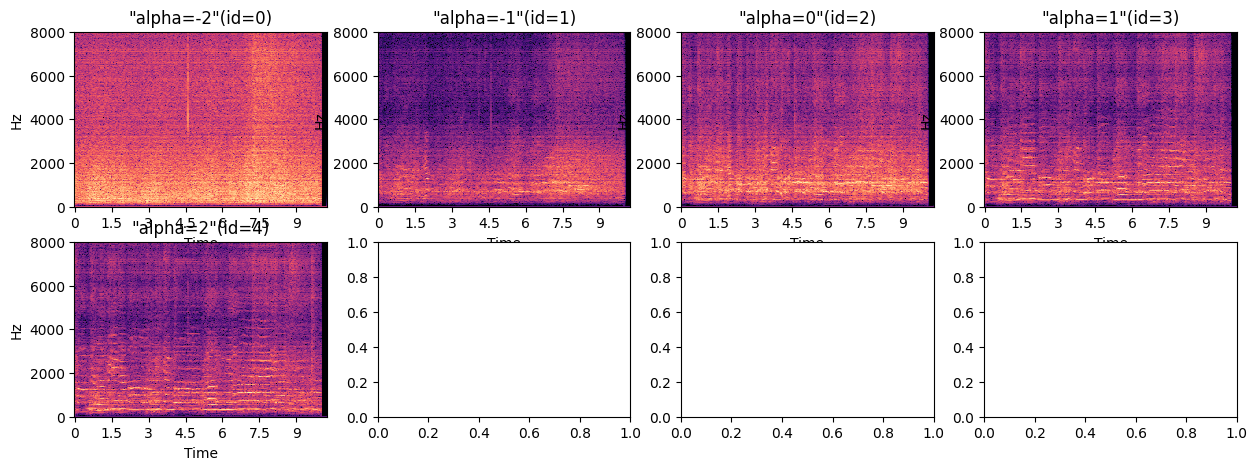

In [31]:
text = "A singing crowd"
describing_word = "singing"


wavs = []
titles = []
for ind, i in enumerate(np.arange(-2,3,1)):
    predicted_wav, _ = sample_diffusion_attention_core(source_text=None, target_text=text, random_seed=random_seed, ddim_steps=20,\
                                                   latent_diffusion=latent_diffusion,
                                                   interpolation_level = None,
                                                   interpolate_terms = ['k','v'],
                                                   target_selected_word_list=[describing_word], target_value_list=[i],
                                                   disable_tqdmoutput = True
                                                   )
    wavs.append(predicted_wav)
    titles.append('"alpha='+str(i) + '"' + "(id=" +str(ind)+")")
    
plot_all(wavs, titles)